In [1]:
import os
os.chdir("/Users/jacksonwalters/Documents/GitHub/enefit-kaggle/predict-energy-behavior-of-prosumers/")
!ls

client.csv                            gas_prices.csv
county_id_to_name_map.json            historical_weather.csv
electricity_prices.csv                public_timeseries_testing_util.py
enefit                                train.csv
example_test_files                    weather_station_to_county_mapping.csv
forecast_weather.csv


In [2]:
import tensorflow as tf

In [5]:
import pickle
cnn_model=pickle.load(open('../models/cnn_model.sav', 'rb'))

Metal device set to: Apple M1


2023-12-15 19:59:38.261490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-15 19:59:38.261819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
import numpy as np
import pandas as pd
from load_data import merged_df

In [23]:
df = merged_df()

loading train data...
loading gas_prices...
loading electricity_prices...
loading forecast_weather...
merging train and gas_prices...
merging electricity_prices...
merging forecast_weather...


In [24]:
df

,county,is_business,product_type,target,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,forecast_date,...,longitude,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,total_precipitation
2928,0,0,1,1.687,0,1.630555e+09,1,2928,0,1.630555e+09,...,21.7,13.691064,7.048120,0.000000,0.043335,0.835190,0.837845,0.971769,-10.245974,0.000090
2929,0,0,1,1.687,0,1.630555e+09,1,2928,0,1.630555e+09,...,22.2,11.859521,5.275171,0.000000,0.158173,0.370102,0.393387,0.535612,-5.105104,0.000000
2930,0,0,1,1.687,0,1.630555e+09,1,2928,0,1.630555e+09,...,22.7,13.141626,6.473901,0.000000,0.196793,0.158386,0.238663,1.305875,-7.770632,0.000018
2931,0,0,1,1.687,0,1.630555e+09,1,2928,0,1.630555e+09,...,23.2,13.239404,7.154810,0.000000,0.119019,0.164139,0.186142,1.239103,-9.215212,0.000080
2932,0,0,1,1.687,0,1.630555e+09,1,2928,0,1.630555e+09,...,23.7,13.527979,6.796289,0.000000,0.226669,0.194443,0.290100,1.273527,-9.503542,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11318433,15,1,3,170.135,1,1.685419e+09,636,2012241,60,1.685419e+09,...,26.2,9.279688,4.392236,0.000000,0.000000,0.881360,0.881360,4.665982,-1.810666,0.000000
11318434,15,1,3,170.135,1,1.685419e+09,636,2012241,60,1.685419e+09,...,26.7,9.466699,4.066309,0.000000,0.000000,0.894925,0.894925,5.060758,-2.906857,0.000000
11318435,15,1,3,170.135,1,1.685419e+09,636,2012241,60,1.685419e+09,...,27.2,9.548608,3.952295,0.000000,0.000000,0.977231,0.977231,5.516080,-3.216916,0.000000
11318436,15,1,3,170.135,1,1.685419e+09,636,2012241,60,1.685419e+09,...,27.7,10.089014,4.984033,0.000000,0.000000,0.999768,0.999768,5.150113,-3.395871,0.000000


In [25]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             6944      
                                                                 
 dense (Dense)               (None, 1, 32)             1056      
                                                                 
 dense_1 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 8,033
Trainable params: 8,033
Non-trainable params: 0
_________________________________________________________________


In [30]:
#create a prediction df with all target values set to zero
predict_df = df[:100_000].copy()

In [31]:
len(df.columns.values)

24

In [64]:
#test-train-validation split on the data
column_indices = {name: i for i, name in enumerate(predict_df.columns)}

n = len(predict_df)

num_features = predict_df.shape[1]

#normalize the data to be predicted
predict_mean = predict_df.mean()
predict_std = predict_df.std()

predict_df = (predict_df - predict_mean) / predict_std

#set the target to zero. this means we don't have any prior knowledge of the targets
predict_df['target'] = 0.

In [38]:
#Handle the indexes and offsets as shown in the diagrams above.
#Split windows of features into (features, labels) pairs.
#Plot the content of the resulting windows.
#Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               predict_df=predict_df,
               label_columns=None):
    # Store the raw data.
    self.predict_df = predict_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def predict(self):
  return self.make_dataset(self.predict_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.predict))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.predict = predict
WindowGenerator.example = example

In [39]:
#multi-step dense network
CONV_WIDTH = 9
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['target'])

In [40]:
conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [9]
Label column name(s): ['target']

In [41]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', cnn_model(conv_window.example[0]).shape)

Input shape: (32, 9, 24)
Output shape: (32, 1, 1)


In [44]:
conv_window.example[1]

<tf.Tensor: shape=(32, 1, 1), dtype=float32, numpy=
array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]], dtype=float32)>

In [45]:
cnn_model(conv_window.example[0])

<tf.Tensor: shape=(32, 1, 1), dtype=float32, numpy=
array([[[-0.04108124]],

       [[-0.1405046 ]],

       [[-0.23227382]],

       [[-0.09397978]],

       [[ 0.4142253 ]],

       [[ 0.34060538]],

       [[ 0.01082196]],

       [[ 0.04284211]],

       [[-0.22528887]],

       [[-0.04152349]],

       [[ 0.19425085]],

       [[-0.11700941]],

       [[ 0.0847007 ]],

       [[-0.08527295]],

       [[ 0.11957521]],

       [[ 0.11403666]],

       [[ 0.04688837]],

       [[-0.14177307]],

       [[-0.13799715]],

       [[ 0.24067834]],

       [[-0.20814413]],

       [[-0.01396788]],

       [[-0.09755435]],

       [[-0.11433008]],

       [[-0.18616745]],

       [[-0.1829505 ]],

       [[-0.2747128 ]],

       [[-0.03510834]],

       [[-0.40205297]],

       [[-0.00761981]],

       [[ 0.01783779]],

       [[-0.08269728]]], dtype=float32)>

In [46]:
#note that the train, test, validation data all have a second "label"representing the target value
cnn_model.predict(conv_window.example[0]) - conv_window.example[1]

<tf.Tensor: shape=(32, 1, 1), dtype=float32, numpy=
array([[[-0.04108124]],

       [[-0.1405046 ]],

       [[-0.23227382]],

       [[-0.09397978]],

       [[ 0.4142253 ]],

       [[ 0.34060538]],

       [[ 0.01082196]],

       [[ 0.04284211]],

       [[-0.22528887]],

       [[-0.04152349]],

       [[ 0.19425085]],

       [[-0.11700941]],

       [[ 0.0847007 ]],

       [[-0.08527295]],

       [[ 0.11957521]],

       [[ 0.11403666]],

       [[ 0.04688837]],

       [[-0.14177307]],

       [[-0.13799715]],

       [[ 0.24067834]],

       [[-0.20814413]],

       [[-0.01396788]],

       [[-0.09755435]],

       [[-0.11433008]],

       [[-0.18616745]],

       [[-0.1829505 ]],

       [[-0.2747128 ]],

       [[-0.03510834]],

       [[-0.40205297]],

       [[-0.00761981]],

       [[ 0.01783779]],

       [[-0.08269728]]], dtype=float32)>

In [75]:
NUM_PREDICTIONS = 100
predictions = []
for i in range(NUM_PREDICTIONS):
    pred_window = next(iter(conv_window.predict))
    predictions.append(np.array(cnn_model(pred_window[0])).mean())

In [71]:
import matplotlib.pyplot as plt

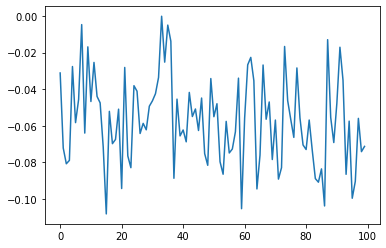

In [76]:
plt.plot(predictions)